In [1]:
import sys
print(sys.executable)

/home/cbb574_ag2995/.conda/envs/myenv/bin/python


In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import pickle
from transformers import AutoModel, AutoImageProcessor
from huggingface_hub import login
import torch.optim as optim
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define constants
BATCH_SIZE = 8
NUM_WORKERS = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "MahmoodLab/UNI2-h"  # Hugging Face model path

print(f"Using device: {DEVICE}")

# Login to HuggingFace
HF_TOKEN = "token"  # Replace with your token
login(token=HF_TOKEN)

/home/cbb574_ag2995/.conda/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [3]:
# Load metadata
train_meta = pd.read_csv('train_meta.csv')
val_meta = pd.read_csv('val_meta.csv')
test_meta = pd.read_csv('test_meta.csv')

print(f"Training samples: {len(train_meta)}")
print(f"Validation samples: {len(val_meta)}")
print(f"Test samples: {len(test_meta)}")

Training samples: 151
Validation samples: 51
Test samples: 68


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.107843..2.64].


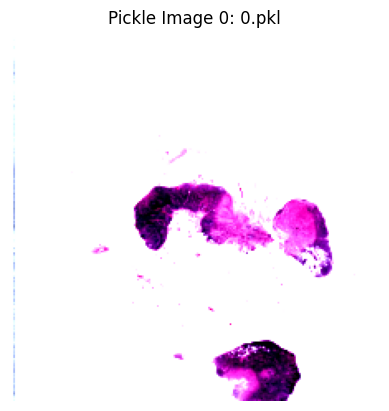

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0728291..2.2216995].


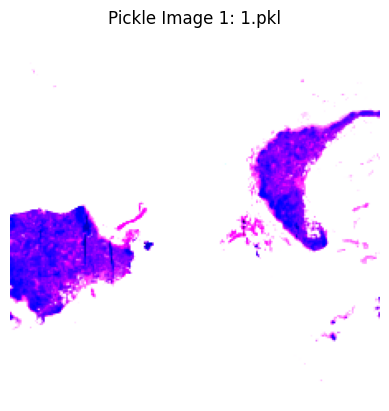

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0903361..2.64].


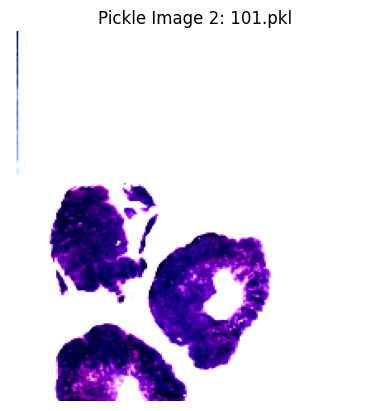

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.460084..2.64].


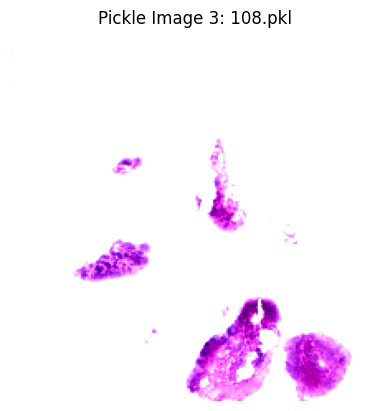

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0378151..2.5877128].


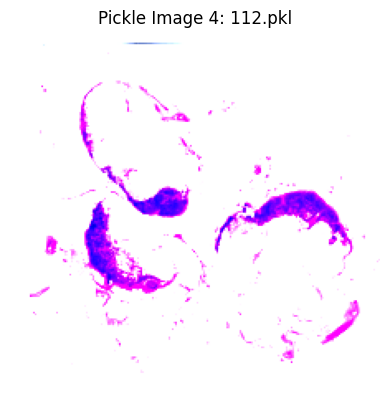

In [4]:
import os
import torch
import matplotlib.pyplot as plt

def show_pickled_images_from_dir(directory, num_images=5):
    pickle_files = [f for f in os.listdir(directory) if f.endswith('.pkl')]
    pickle_files = sorted(pickle_files)[:num_images]

    for idx, file in enumerate(pickle_files):
        file_path = os.path.join(directory, file)
        img = torch.load(file_path)

        # Remove batch dimension if present
        if img.ndim == 4 and img.shape[0] == 1:
            img = img.squeeze(0)  # (3, 224, 224)

        img_np = img.numpy()
        if img_np.ndim == 2:
            plt.imshow(img_np, cmap='gray')
        elif img_np.ndim == 3 and img_np.shape[0] in [1, 3]:  # (C, H, W)
            plt.imshow(img_np.transpose(1, 2, 0))
        else:
            raise ValueError(f"Unsupported image shape: {img_np.shape}")

        plt.title(f"Pickle Image {idx}: {file}")
        plt.axis('off')
        plt.show()

show_pickled_images_from_dir("test", num_images=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.93277305..2.64].


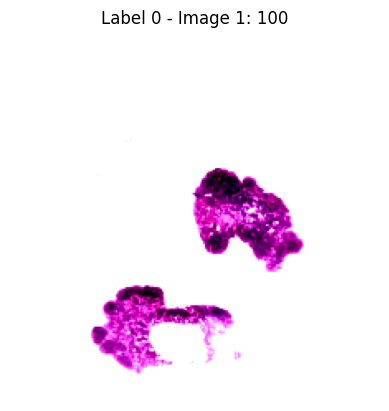

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.897759..2.64].


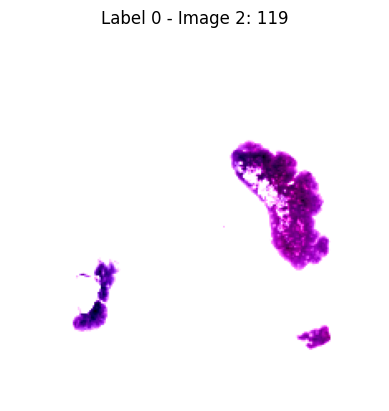

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6855742..2.4831376].


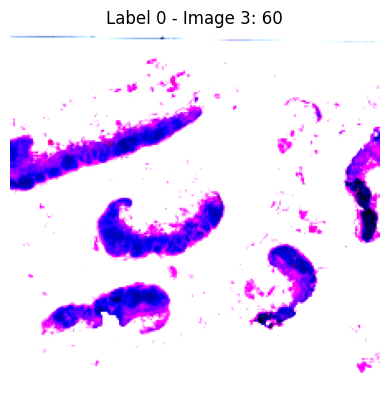

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.457983..2.64].


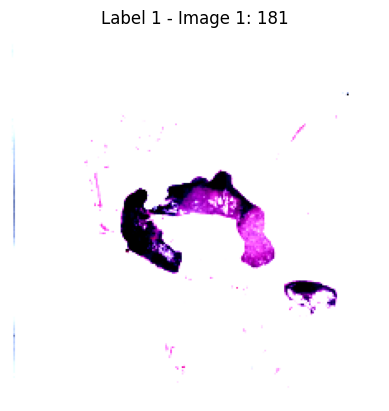

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6855742..2.4134207].


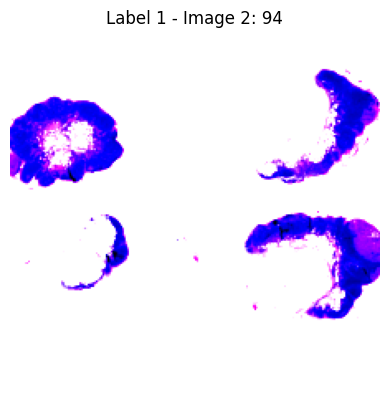

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7906162..2.3959913].


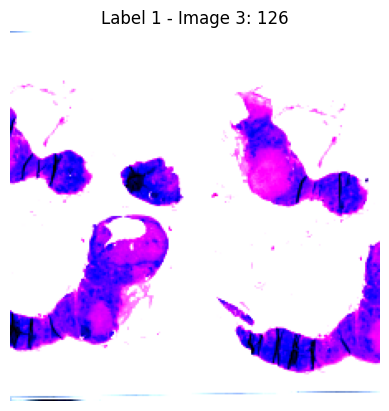

In [5]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt

def show_images_by_label(meta_csv_path, image_dir, num_images_per_label=3):
    # Load metadata
    df = pd.read_csv(meta_csv_path)

    # Filter by label
    label_0_ids = df[df['label'] == 0]['image_id'].tolist()
    label_1_ids = df[df['label'] == 1]['image_id'].tolist()

    # Take first N from each
    selected_ids = {
        0: label_0_ids[:num_images_per_label],
        1: label_1_ids[:num_images_per_label]
    }

    for label in [0, 1]:
        for idx, image_id in enumerate(selected_ids[label]):
            file_path = os.path.join(image_dir, f"{image_id}.pkl")
            img = torch.load(file_path)

            # Remove batch dimension if present
            if img.ndim == 4 and img.shape[0] == 1:
                img = img.squeeze(0)  # (3, 224, 224)

            img_np = img.numpy()
            if img_np.ndim == 2:
                plt.imshow(img_np, cmap='gray')
            elif img_np.ndim == 3 and img_np.shape[0] in [1, 3]:  # (C, H, W)
                plt.imshow(img_np.transpose(1, 2, 0))
            else:
                raise ValueError(f"Unsupported image shape: {img_np.shape}")

            plt.title(f"Label {label} - Image {idx + 1}: {image_id}")
            plt.axis('off')
            plt.show()

# Example usage:
show_images_by_label("train_meta.csv", "train", num_images_per_label=3)

In [6]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Sampler
from torchvision import transforms
import random
from PIL import Image
import cv2
import os

# Function to load images using torch.load
def load_image(image_id, split):
    """
    Load an image file using torch.load
    
    Args:
        image_id: ID of the image
        split: 'train', 'val', or 'test' folder
        
    Returns:
        tensor: PyTorch tensor of the image or None on error
    """
    file_path = f"{split}/{image_id}.pkl"
    
    if not os.path.exists(file_path):
        print(f"File does not exist: {file_path}")
        return None
    
    try:
        # Load using torch.load
        img = torch.load(file_path)
        
        # Remove batch dimension if present
        if img.ndim == 4 and img.shape[0] == 1:
            img = img.squeeze(0)  # (3, 224, 224)
            
        return img
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

class StandardScalerTransform:
    """
    Apply standard scaler normalization (x-mu)/sigma to each image individually
    """
    def __call__(self, tensor):
        # Apply per channel standardization
        for c in range(tensor.shape[0]):
            channel = tensor[c, :, :]
            mean = torch.mean(channel)
            std = torch.std(channel)
            # Add small epsilon to avoid division by zero
            tensor[c, :, :] = (channel - mean) / (std + 1e-8)
        return tensor

class AugmentedPathologyDataset(Dataset):
    def __init__(self, meta_df, split, transform=None, strong_augment=True, num_augmentations=300, apply_standardization=True):
        """
        Dataset for pathology images with augmentation
        
        Args:
            meta_df: DataFrame with image_id and label
            split: 'train', 'val', or 'test'
            transform: Optional transforms to apply to images
            strong_augment: Whether to apply strong augmentations
            num_augmentations: Number of augmented versions to create per image
            apply_standardization: Whether to apply standard scaler normalization
        """
        self.meta_df = meta_df
        self.split = split
        self.base_transform = transform
        self.strong_augment = strong_augment
        self.has_labels = 'label' in meta_df.columns
        self.apply_standardization = apply_standardization
        
        # For visualization compatibility
        self.num_augmentations = num_augmentations
        
        # Calculate effective dataset size
        self.effective_size = len(meta_df) * self.num_augmentations
        
        # Define strong augmentation transform for torch tensors
        self.tensor_transforms = transforms.Compose([
            # Custom transforms for tensor data
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        ])
        
        # Lighter validation transforms
        self.val_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
        ])
        
        # Standard scaler normalization
        self.standardizer = StandardScalerTransform()
        
        # Set random seed for reproducibility
        random.seed(42)
        torch.manual_seed(42)
    
    def __len__(self):
        return self.effective_size
    
    def __getitem__(self, idx):
        # Map virtual index to actual image index and augmentation index
        real_idx = idx // self.num_augmentations
        aug_idx = idx % self.num_augmentations
        
        # Ensure real_idx is within bounds of metadata
        real_idx = real_idx % len(self.meta_df)
        
        # Get image_id
        row = self.meta_df.iloc[real_idx]
        image_id = row['image_id']
        
        # Load image tensor
        try:
            file_path = f"{self.split}/{image_id}.pkl"
            img_tensor = torch.load(file_path)
            
            # Remove batch dimension if present
            if img_tensor.ndim == 4 and img_tensor.shape[0] == 1:
                img_tensor = img_tensor.squeeze(0)  # (3, 224, 224)
            
            # Ensure we have a 3D tensor
            if img_tensor.ndim != 3:
                print(f"Warning: Unusual tensor shape {img_tensor.shape} for {image_id}")
                img_tensor = torch.zeros((3, 224, 224))
            
        except Exception as e:
            print(f"Error loading {image_id}: {e}")
            img_tensor = torch.zeros((3, 224, 224))
        
        # Apply base transforms if provided
        if self.base_transform is not None:
            try:
                img_tensor = self.base_transform(img_tensor)
            except Exception as e:
                print(f"Base transform error for {image_id}: {e}")
        
        # Apply augmentation with different random seeds based on aug_idx
        torch.manual_seed(aug_idx + real_idx * 100)  # Different seed for each virtual sample
        random.seed(aug_idx + real_idx * 100)
        
        # Apply augmentation based on split and settings
        if self.split == 'train' and self.strong_augment:
            try:
                img_tensor = self.tensor_transforms(img_tensor)
            except Exception as e:
                print(f"Strong augment error for {image_id}: {e}")
        elif self.split == 'val':
            try:
                img_tensor = self.val_transforms(img_tensor)
            except Exception as e:
                print(f"Val augment error for {image_id}: {e}")
        
        # Apply standard scaler normalization
        if self.apply_standardization:
            img_tensor = self.standardizer(img_tensor)
        
        # Create return dictionary
        result = {
            'image_id': image_id,
            'image': img_tensor
        }
        
        # Add label if available
        if self.has_labels:
            label = row['label']
            result['label'] = torch.tensor(label, dtype=torch.long)
        
        return result

# Define transforms without normalization since we'll apply standard scaling
tensor_transforms = transforms.Compose([
    # Custom transforms for tensor data
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
])

# Create datasets with the augmented dataset class and standard scaling
train_dataset = AugmentedPathologyDataset(
    train_meta, 
    'train', 
    transform=None,  # No base transform needed since it's handled internally
    strong_augment=True,
    num_augmentations=1,  # Creates ~151 effective training samples
    apply_standardization=True  # Apply standard scaler normalization
)

val_dataset = AugmentedPathologyDataset(
    val_meta, 
    'val', 
    transform=None,  # No base transform needed since it's handled internally
    strong_augment=False,
    num_augmentations=1,  # Creates ~68 effective validation samples
    apply_standardization=True  # Apply standard scaler normalization
)

test_dataset = AugmentedPathologyDataset(
    test_meta, 
    'test', 
    transform=None,  # No base transform needed since it's handled internally
    strong_augment=False,
    num_augmentations=1,  # No augmentation for test set
    apply_standardization=True  # Apply standard scaler normalization
)

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS
)

print(f"Effective training samples: {len(train_dataset)}")
print(f"Effective validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Function to visualize standardization effects
def visualize_standardization_effect(dataset, index=0):
    """
    Visualize the effect of standardization on an image
    
    Args:
        dataset: Dataset containing the images
        index: Index of the image to visualize
    """
    import matplotlib.pyplot as plt
    from torchvision.utils import make_grid
    
    # Get original image without standardization
    dataset.apply_standardization = False
    sample_original = dataset[index]
    img_original = sample_original['image']
    
    # Get standardized image
    dataset.apply_standardization = True
    sample_standardized = dataset[index]
    img_standardized = sample_standardized['image']
    
    # Reset dataset
    dataset.apply_standardization = True
    
    # Create a grid of images
    img_grid = make_grid([img_original, img_standardized], nrow=2)
    img_grid = img_grid.permute(1, 2, 0).numpy()
    
    # Display images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_original.permute(1, 2, 0).numpy())
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_standardized.permute(1, 2, 0).numpy())
    plt.title('Standardized Image (x-μ)/σ')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('standardization_effect.png')
    plt.close()
    
    print("Visualization saved to 'standardization_effect.png'")
    
    # Print statistics
    print("Original Image Stats:")
    for c in range(3):
        channel = img_original[c].numpy()
        print(f"Channel {c}: Mean = {channel.mean():.4f}, Std = {channel.std():.4f}")
    
    print("\nStandardized Image Stats:")
    for c in range(3):
        channel = img_standardized[c].numpy()
        print(f"Channel {c}: Mean = {channel.mean():.4f}, Std = {channel.std():.4f}")

# Uncomment to visualize standardization effect
visualize_standardization_effect(train_dataset, index=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0862281..0.52787536].


Effective training samples: 151
Effective validation samples: 51
Test samples: 68
Visualization saved to 'standardization_effect.png'
Original Image Stats:
Channel 0: Mean = 0.8062, Std = 0.3898
Channel 1: Mean = 0.7860, Std = 0.4054
Channel 2: Mean = 0.8074, Std = 0.3870

Standardized Image Stats:
Channel 0: Mean = -0.0000, Std = 1.0000
Channel 1: Mean = 0.0000, Std = 1.0000
Channel 2: Mean = -0.0000, Std = 1.0000



Visualizing training samples:
Image shape: torch.Size([3, 224, 224])
Image shape: torch.Size([3, 224, 224])
Image shape: torch.Size([3, 224, 224])
Image shape: torch.Size([3, 224, 224])
Image shape: torch.Size([3, 224, 224])


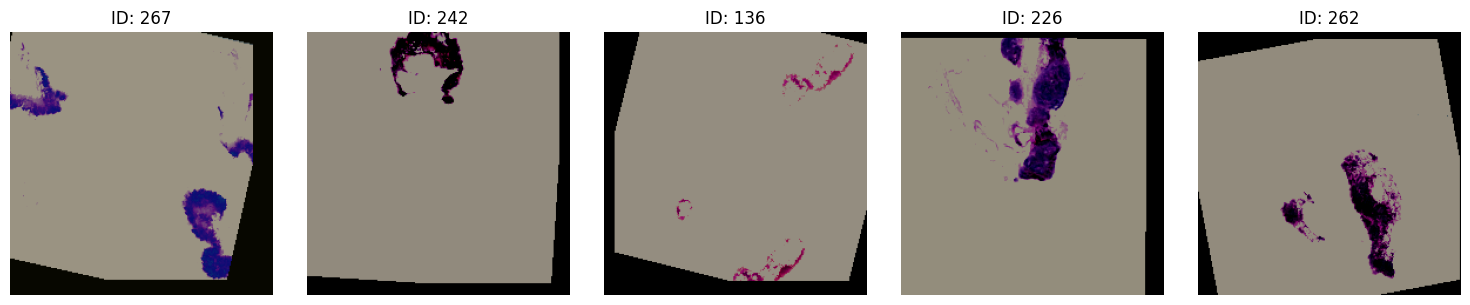


Visualizing validation samples:
Image shape: torch.Size([3, 224, 224])
Image shape: torch.Size([3, 224, 224])
Image shape: torch.Size([3, 224, 224])
Image shape: torch.Size([3, 224, 224])
Image shape: torch.Size([3, 224, 224])


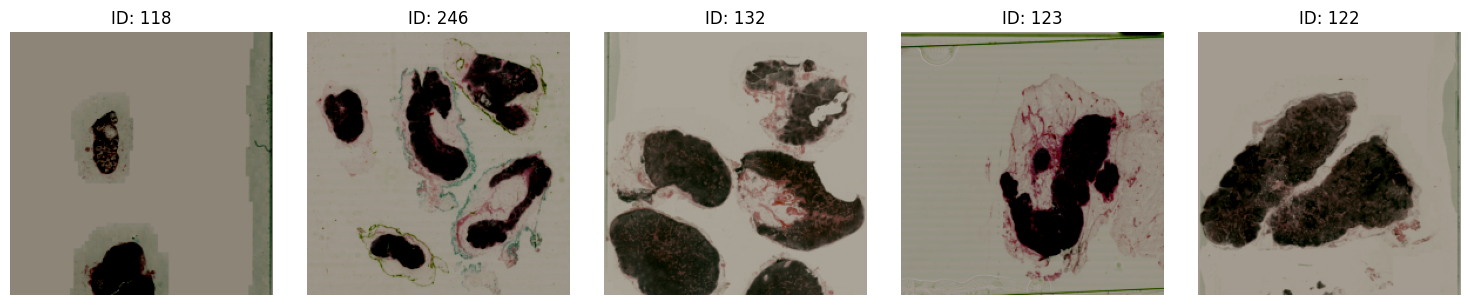


Visualizing test samples:
Image shape: torch.Size([3, 224, 224])
Image shape: torch.Size([3, 224, 224])
Image shape: torch.Size([3, 224, 224])
Image shape: torch.Size([3, 224, 224])
Image shape: torch.Size([3, 224, 224])


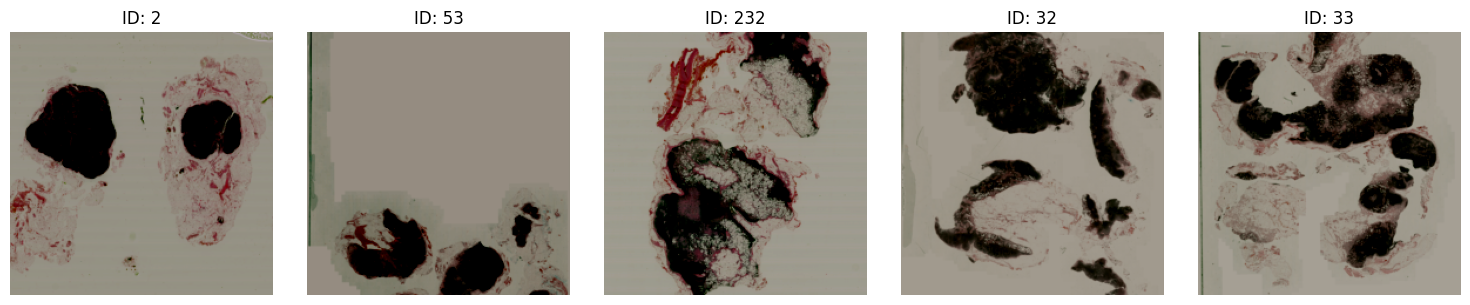


Plotting class distribution:


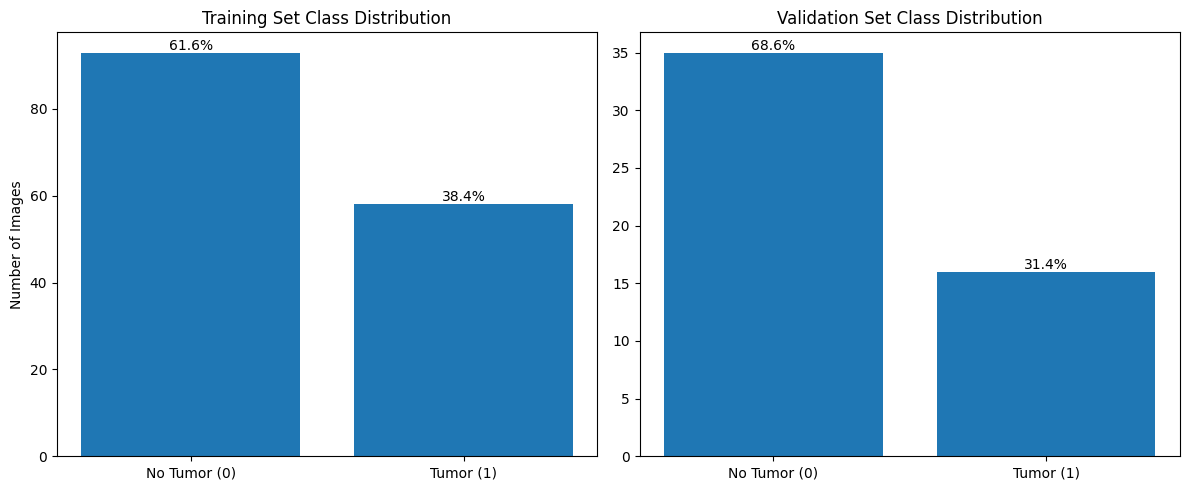


Analyzing image statistics:
Image statistics (normalized):
  Mean: tensor([-1.1718e-07, -2.8307e-07, -2.5415e-07])
  Std: tensor([1.0000, 1.0000, 1.0000])
  Min: tensor([-2.7171, -2.6020, -2.7403])
  Max: tensor([0.8540, 0.8067, 0.6777])

Image statistics (denormalized):
  Mean: tensor([0.4850, 0.4560, 0.4060])
  Std: tensor([0.2290, 0.2240, 0.2250])
  Min: tensor([-0.1372, -0.1268, -0.2106])
  Max: tensor([0.6806, 0.6367, 0.5585])

Visualizing samples by class:


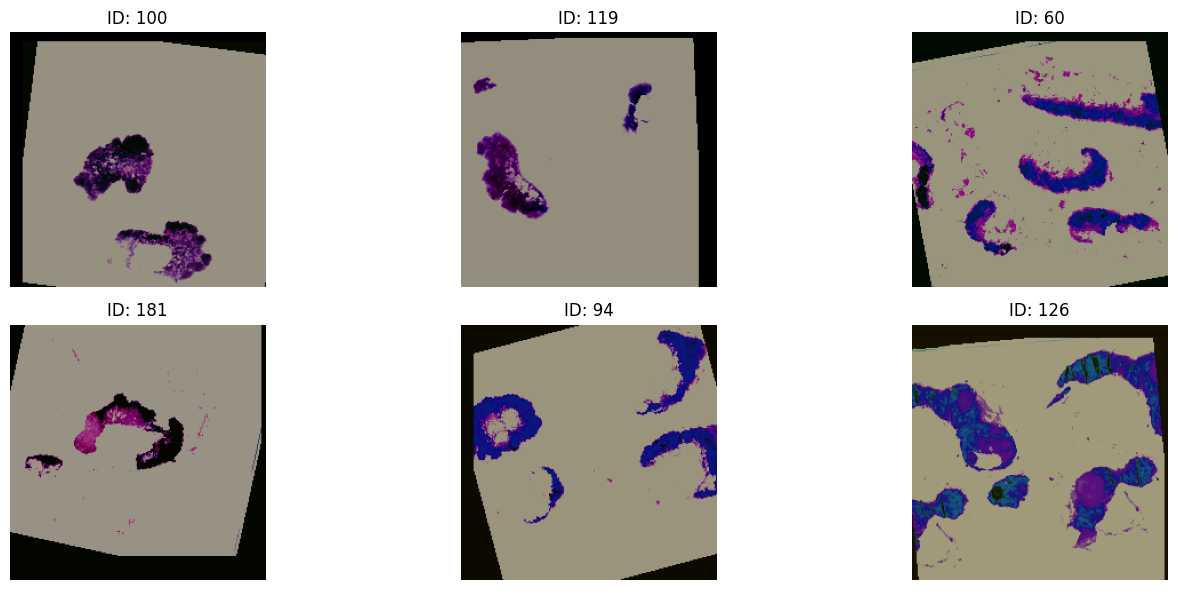


Testing data loaders:
Testing Training loader...
  Success! Batch size: 8
  Image shape: torch.Size([8, 3, 224, 224])
  Label shape: torch.Size([8])
  Label counts: tensor([6, 2])
Testing Validation loader...
  Success! Batch size: 8
  Image shape: torch.Size([8, 3, 224, 224])
  Label shape: torch.Size([8])
  Label counts: tensor([4, 4])
Testing Test loader...
  Success! Batch size: 8
  Image shape: torch.Size([8, 3, 224, 224])


In [7]:
# Function to visualize samples from the dataset
def visualize_samples(loader, num_samples=5):
    """
    Visualize samples from a data loader with improved error handling
    
    Args:
        loader: DataLoader object
        num_samples: Number of samples to visualize
    """
    # Get a batch
    batch = next(iter(loader))
    images = batch['image']
    image_ids = batch['image_id']
    
    # Number of samples to display
    n_samples = min(num_samples, len(images))
    
    # Create figure
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))
    if n_samples == 1:
        axes = [axes]
    
    # Mean and std for denormalization
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    
    for i in range(n_samples):
        try:
            # Get the image tensor
            img = images[i].clone()
            
            # Print shape for debugging
            print(f"Image shape: {img.shape}")
            
            # Handle different tensor formats
            if len(img.shape) == 3:  # (C,H,W) or (H,W,C)
                if img.shape[0] == 3 or img.shape[0] == 1:  # (C,H,W)
                    # Denormalize
                    for c in range(img.shape[0]):
                        img[c] = img[c] * std[c] + mean[c]
                    
                    # Convert to numpy and transpose to (H,W,C)
                    img_np = img.numpy().transpose(1, 2, 0)
                else:  # (H,W,C)
                    # Denormalize
                    for c in range(img.shape[2]):
                        img[:,:,c] = img[:,:,c] * std[c] + mean[c]
                    
                    # Already in (H,W,C)
                    img_np = img.numpy()
            else:
                print(f"Unexpected image shape: {img.shape}")
                # Create a blank image
                img_np = np.zeros((224, 224, 3))
            
            # Ensure values are in [0,1]
            img_np = np.clip(img_np, 0, 1)
            
            # Display
            axes[i].imshow(img_np)
            axes[i].set_title(f"ID: {image_ids[i]}")
            
            # Add label if available
            if 'label' in batch:
                label = batch['label'][i].item()
                label_text = "Tumor" if label == 1 else "No Tumor"
                axes[i].set_xlabel(f"Label: {label_text}")
                
            axes[i].axis('off')
        except Exception as e:
            print(f"Error displaying image {i}: {e}")
            # Display blank image with error message
            axes[i].text(0.5, 0.5, f"Error: {e}", ha='center', va='center', wrap=True)
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Function to analyze and plot class distribution
def plot_class_distribution():
    """Visualize the class distribution in train and validation sets"""
    plt.figure(figsize=(12, 5))
    
    # Training set
    if 'label' in train_meta.columns:
        plt.subplot(1, 2, 1)
        train_dist = train_meta['label'].value_counts().sort_index()
        classes = ['No Tumor (0)', 'Tumor (1)']
        plt.bar(classes, [train_dist.get(0, 0), train_dist.get(1, 0)])
        plt.title('Training Set Class Distribution')
        plt.ylabel('Number of Images')
        
        # Display percentages
        total = len(train_meta)
        for i, count in enumerate([train_dist.get(0, 0), train_dist.get(1, 0)]):
            percentage = (count / total) * 100
            plt.text(i, count, f"{percentage:.1f}%", ha='center', va='bottom')
    
    # Validation set
    if 'label' in val_meta.columns:
        plt.subplot(1, 2, 2)
        val_dist = val_meta['label'].value_counts().sort_index()
        classes = ['No Tumor (0)', 'Tumor (1)']
        plt.bar(classes, [val_dist.get(0, 0), val_dist.get(1, 0)])
        plt.title('Validation Set Class Distribution')
        
        # Display percentages
        total = len(val_meta)
        for i, count in enumerate([val_dist.get(0, 0), val_dist.get(1, 0)]):
            percentage = (count / total) * 100
            plt.text(i, count, f"{percentage:.1f}%", ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Function to check image statistics
def analyze_image_statistics(loader):
    """
    Analyze image statistics (mean, std, min, max)
    
    Args:
        loader: DataLoader object
    """
    # Get a batch
    batch = next(iter(loader))
    images = batch['image']
    
    # Calculate statistics
    means = images.mean(dim=[0, 2, 3])
    stds = images.std(dim=[0, 2, 3])
    mins = images.min(dim=3)[0].min(dim=2)[0].min(dim=0)[0]
    maxs = images.max(dim=3)[0].max(dim=2)[0].max(dim=0)[0]
    
    print("Image statistics (normalized):")
    print(f"  Mean: {means}")
    print(f"  Std: {stds}")
    print(f"  Min: {mins}")
    print(f"  Max: {maxs}")
    
    # Display original image statistics (before normalization)
    # Denormalize
    mean = torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)
    
    denorm_images = images * std + mean
    denorm_means = denorm_images.mean(dim=[0, 2, 3])
    denorm_stds = denorm_images.std(dim=[0, 2, 3])
    denorm_mins = denorm_images.min(dim=3)[0].min(dim=2)[0].min(dim=0)[0]
    denorm_maxs = denorm_images.max(dim=3)[0].max(dim=2)[0].max(dim=0)[0]
    
    print("\nImage statistics (denormalized):")
    print(f"  Mean: {denorm_means}")
    print(f"  Std: {denorm_stds}")
    print(f"  Min: {denorm_mins}")
    print(f"  Max: {denorm_maxs}")

# Function to visualize samples by class
def visualize_samples_by_class(dataset, num_samples_per_class=3):
    """
    Visualize samples from each class
    
    Args:
        dataset: Dataset object
        num_samples_per_class: Number of samples to visualize per class
    """
    if 'label' not in dataset.meta_df.columns:
        print("No labels available")
        return
    
    # Get indices for each class
    class_0_indices = dataset.meta_df[dataset.meta_df['label'] == 0].index[:num_samples_per_class]
    class_1_indices = dataset.meta_df[dataset.meta_df['label'] == 1].index[:num_samples_per_class]
    
    # Create figure
    fig, axes = plt.subplots(2, num_samples_per_class, figsize=(15, 6))
    
    # Mean and std for denormalization
    mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    
    # Plot class 0 samples
    for i, idx in enumerate(class_0_indices):
        sample = dataset[idx]
        img = sample['image']
        
        # Denormalize
        img = img * std + mean
        
        # Convert to numpy
        img_np = img.numpy().transpose(1, 2, 0)
        img_np = np.clip(img_np, 0, 1)
        
        # Plot
        axes[0, i].imshow(img_np)
        axes[0, i].set_title(f"ID: {sample['image_id']}")
        axes[0, i].set_xlabel("No Tumor")
        axes[0, i].axis('off')
    
    # Plot class 1 samples
    for i, idx in enumerate(class_1_indices):
        sample = dataset[idx]
        img = sample['image']
        
        # Denormalize
        img = img * std + mean
        
        # Convert to numpy
        img_np = img.numpy().transpose(1, 2, 0)
        img_np = np.clip(img_np, 0, 1)
        
        # Plot
        axes[1, i].imshow(img_np)
        axes[1, i].set_title(f"ID: {sample['image_id']}")
        axes[1, i].set_xlabel("Tumor")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Check data loaders by running them and catching any errors
def test_data_loaders():
    """Test all data loaders to make sure they work"""
    loaders = [
        ("Training", train_loader),
        ("Validation", val_loader),
        ("Test", test_loader)
    ]
    
    for name, loader in loaders:
        print(f"Testing {name} loader...")
        try:
            batch = next(iter(loader))
            print(f"  Success! Batch size: {len(batch['image'])}")
            print(f"  Image shape: {batch['image'].shape}")
            if 'label' in batch:
                print(f"  Label shape: {batch['label'].shape}")
                print(f"  Label counts: {torch.bincount(batch['label'])}")
        except Exception as e:
            print(f"  Error: {e}")

# Run all the visualization and analysis functions
print("\nVisualizing training samples:")
visualize_samples(train_loader)

print("\nVisualizing validation samples:")
visualize_samples(val_loader)

print("\nVisualizing test samples:")
visualize_samples(test_loader)

print("\nPlotting class distribution:")
plot_class_distribution()

print("\nAnalyzing image statistics:")
analyze_image_statistics(train_loader)

print("\nVisualizing samples by class:")
visualize_samples_by_class(train_dataset)

print("\nTesting data loaders:")
test_data_loaders()

In [8]:
import timm
import torch.nn as nn

class TumorClassifier(nn.Module):
    def __init__(self, model_name="hf_hub:MahmoodLab/UNI2-h", freeze_backbone=False, **timm_kwargs):
        """
        Tumor classifier based on UNI2-h model using timm
        
        Args:
            model_name: Model name or path for timm
            freeze_backbone: Whether to freeze the backbone
        """
        super(TumorClassifier, self).__init__()
        
        # Load pretrained model using timm
        self.backbone = timm.create_model(model_name, pretrained=True, **timm_kwargs)
        
        # Get output features dimension
        # UNI2-h uses a ViT backbone, so we get the num_features from the model
        if hasattr(self.backbone, 'num_features'):
            hidden_size = self.backbone.num_features
        else:
            # Default fallback
            hidden_size = 768  # Common size for transformer models
        
        # Freeze backbone if requested
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        # Replace the head
        if hasattr(self.backbone, 'head'):
            self.backbone.head = nn.Identity()
        elif hasattr(self.backbone, 'fc'):
            self.backbone.fc = nn.Identity()
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )
        # # Classification head
        # self.classifier = nn.Sequential(
        #     nn.Linear(hidden_size, 128),
        #     nn.ReLU(),
        #     nn.Dropout(0.3),
        #     nn.Linear(128, 1)
        # )
    
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: Image tensor of shape (batch_size, channels, height, width)
            
        Returns:
            logits: Classification logits
        """
        # Get features from backbone
        features = self.backbone(x)
        
        # Classification
        logits = self.classifier(features)
        
        return logits.squeeze(-1)  # Remove last dimension for binary classification

In [9]:
def train_epoch(model, dataloader, optimizer, criterion, scheduler, device):
    """Train for one epoch
    
    Args:
        model: The model to train
        dataloader: DataLoader for training data
        optimizer: Optimizer for updating weights
        criterion: Loss function
        scheduler: Learning rate scheduler
        device: Device to run training on (cuda/cpu)
        
    Returns:
        tuple: (epoch_loss, accuracy, precision, recall, f1)
    """
    # Set model to training mode
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    # Create progress bar
    progress_bar = tqdm(dataloader, desc="Training")
    
    # Iterate through batches
    for batch in progress_bar:
        # Get data and move to device
        images = batch['image'].to(device)
        labels = batch['label'].float().to(device)  # Use float for BCEWithLogitsLoss
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Update metrics
        running_loss += loss.item()
        
        # Calculate predictions
        preds = (torch.sigmoid(outputs) > 0.5).float().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        
        # Update progress bar with current loss
        progress_bar.set_postfix({"loss": loss.item()})
    
    # Calculate final metrics
    epoch_loss = running_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    return epoch_loss, accuracy, precision, recall, f1

In [10]:
def validate(model, dataloader, criterion, device):
    """Validate model"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            # Get data
            images = batch['image'].to(device)
            labels = batch['label'].float().to(device)
            
            # Forward pass - Changed to pass images directly
            outputs = model(images)  # Changed from model(pixel_values=images)
            loss = criterion(outputs, labels)
            
            # Update metrics
            running_loss += loss.item()
            
            # Get predictions
            preds = (torch.sigmoid(outputs) > 0.5).float().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    epoch_loss = running_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    return epoch_loss, accuracy, precision, recall, f1, cm

In [11]:
def train_model(model, train_loader, val_loader, num_epochs=10, 
                learning_rate=2e-5, weight_decay=0.01, save_dir='models'):
    """Train and evaluate model"""
    # Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = model.to(device)
    
    # Create save directory
    os.makedirs(save_dir, exist_ok=True)
    
    # Loss function - binary cross entropy with logits for binary classification
    criterion = nn.BCEWithLogitsLoss()
    
    # Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Learning rate scheduler
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )
    
    # Training loop
    best_val_f1 = 0.0
    best_model_path = os.path.join(save_dir, 'best_tumor_classifier.pth')
    
    # Lists to store metrics
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    train_f1s = []
    val_f1s = []
    train_precisions = []
    val_precisions = []
    train_recalls = []
    val_recalls = []
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train
        train_loss, train_acc, train_precision, train_recall, train_f1 = train_epoch(
            model, train_loader, optimizer, criterion, scheduler, device
        )
        
        # Validate
        val_loss, val_acc, val_precision, val_recall, val_f1, val_cm = validate(
            model, val_loader, criterion, device
        )
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)
        train_precisions.append(train_precision)
        val_precisions.append(val_precision)
        train_recalls.append(train_recall)
        val_recalls.append(val_recall)
        
        # Print metrics
        print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")
        
        # Print confusion matrix
        print("\nConfusion Matrix:")
        print(val_cm)
        
        # Save the best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_f1': val_f1,
                'val_acc': val_acc,
                'val_precision': val_precision,
                'val_recall': val_recall,
            }, best_model_path)
            print(f"Saved best model with F1 score: {val_f1:.4f}")
    
    # Plot training curves
    epochs = range(1, num_epochs + 1)
    
    # Create a 2x2 grid of plots
    plt.figure(figsize=(16, 12))
    
    # Plot 1: Loss curves
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Plot 3: F1 Score
    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_f1s, 'b-', label='Training F1')
    plt.plot(epochs, val_f1s, 'r-', label='Validation F1')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    
    # Plot 4: Precision and Recall
    plt.subplot(2, 2, 4)
    plt.plot(epochs, train_precisions, 'b--', label='Training Precision')
    plt.plot(epochs, val_precisions, 'r--', label='Validation Precision')
    plt.plot(epochs, train_recalls, 'b-', label='Training Recall')
    plt.plot(epochs, val_recalls, 'r-', label='Validation Recall')
    plt.title('Training and Validation Precision/Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_metrics.png'))
    plt.show()
    
    # Save all metrics to CSV for further analysis
    metrics_df = pd.DataFrame({
        'epoch': epochs,
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accs,
        'val_accuracy': val_accs,
        'train_f1': train_f1s,
        'val_f1': val_f1s,
        'train_precision': train_precisions,
        'val_precision': val_precisions,
        'train_recall': train_recalls,
        'val_recall': val_recalls
    })
    metrics_df.to_csv(os.path.join(save_dir, 'training_metrics.csv'), index=False)
    
    print(f"\nTraining complete. Best validation F1 score: {best_val_f1:.4f}")
    print(f"Training metrics saved to {os.path.join(save_dir, 'training_metrics.png')}")
    print(f"Detailed metrics data saved to {os.path.join(save_dir, 'training_metrics.csv')}")
    
    return best_model_path

In [12]:
# Define required parameters for UNI2-h
timm_kwargs = {
    'img_size': 224,
    'patch_size': 14,
    'depth': 24,
    'num_heads': 24,
    'init_values': 1e-5,
    'embed_dim': 1536,
    'mlp_ratio': 2.66667*2,
    'num_classes': 0,
    'no_embed_class': True,
    'mlp_layer': timm.layers.SwiGLUPacked,
    'act_layer': torch.nn.SiLU,
    'reg_tokens': 8,
    'dynamic_img_size': True
}
# Create model
model = TumorClassifier(model_name="hf_hub:MahmoodLab/UNI2-h", freeze_backbone=True, **timm_kwargs)

Using device: cuda

Epoch 1/20


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


Train Loss: 0.1742, Acc: 0.9735, F1: 0.9649
Val Loss: 0.9454, Acc: 0.4314, F1: 0.4082
Val Precision: 0.3030, Recall: 0.6250

Confusion Matrix:
[[12 23]
 [ 6 10]]
Saved best model with F1 score: 0.4082

Epoch 2/20


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


Train Loss: 0.1679, Acc: 0.9603, F1: 0.9474
Val Loss: 0.9773, Acc: 0.4706, F1: 0.4490
Val Precision: 0.3333, Recall: 0.6875

Confusion Matrix:
[[13 22]
 [ 5 11]]
Saved best model with F1 score: 0.4490

Epoch 3/20


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


Train Loss: 0.1560, Acc: 0.9536, F1: 0.9391
Val Loss: 1.0130, Acc: 0.4314, F1: 0.4082
Val Precision: 0.3030, Recall: 0.6250

Confusion Matrix:
[[12 23]
 [ 6 10]]

Epoch 4/20


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


Train Loss: 0.1209, Acc: 0.9868, F1: 0.9828
Val Loss: 1.1975, Acc: 0.4510, F1: 0.4815
Val Precision: 0.3421, Recall: 0.8125

Confusion Matrix:
[[10 25]
 [ 3 13]]
Saved best model with F1 score: 0.4815

Epoch 5/20


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Train Loss: 0.1033, Acc: 0.9934, F1: 0.9913
Val Loss: 1.0895, Acc: 0.4706, F1: 0.4490
Val Precision: 0.3333, Recall: 0.6875

Confusion Matrix:
[[13 22]
 [ 5 11]]

Epoch 6/20


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


Train Loss: 0.1090, Acc: 0.9868, F1: 0.9828
Val Loss: 1.1906, Acc: 0.4510, F1: 0.4615
Val Precision: 0.3333, Recall: 0.7500

Confusion Matrix:
[[11 24]
 [ 4 12]]

Epoch 7/20


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


Train Loss: 0.0831, Acc: 0.9934, F1: 0.9913
Val Loss: 1.1801, Acc: 0.4510, F1: 0.4400
Val Precision: 0.3235, Recall: 0.6875

Confusion Matrix:
[[12 23]
 [ 5 11]]

Epoch 8/20


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Train Loss: 0.0815, Acc: 1.0000, F1: 1.0000
Val Loss: 1.2639, Acc: 0.4706, F1: 0.4906
Val Precision: 0.3514, Recall: 0.8125

Confusion Matrix:
[[11 24]
 [ 3 13]]
Saved best model with F1 score: 0.4906

Epoch 9/20


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


Train Loss: 0.0647, Acc: 1.0000, F1: 1.0000
Val Loss: 1.3097, Acc: 0.4510, F1: 0.4615
Val Precision: 0.3333, Recall: 0.7500

Confusion Matrix:
[[11 24]
 [ 4 12]]

Epoch 10/20


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Train Loss: 0.0599, Acc: 1.0000, F1: 1.0000
Val Loss: 1.2047, Acc: 0.4902, F1: 0.4800
Val Precision: 0.3529, Recall: 0.7500

Confusion Matrix:
[[13 22]
 [ 4 12]]

Epoch 11/20


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Train Loss: 0.0599, Acc: 1.0000, F1: 1.0000
Val Loss: 1.3911, Acc: 0.4706, F1: 0.4906
Val Precision: 0.3514, Recall: 0.8125

Confusion Matrix:
[[11 24]
 [ 3 13]]

Epoch 12/20


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Train Loss: 0.0501, Acc: 1.0000, F1: 1.0000
Val Loss: 1.3008, Acc: 0.4706, F1: 0.4706
Val Precision: 0.3429, Recall: 0.7500

Confusion Matrix:
[[12 23]
 [ 4 12]]

Epoch 13/20


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


Train Loss: 0.0528, Acc: 1.0000, F1: 1.0000
Val Loss: 1.3135, Acc: 0.4706, F1: 0.4706
Val Precision: 0.3429, Recall: 0.7500

Confusion Matrix:
[[12 23]
 [ 4 12]]

Epoch 14/20


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


Train Loss: 0.0453, Acc: 1.0000, F1: 1.0000
Val Loss: 1.3450, Acc: 0.4510, F1: 0.4615
Val Precision: 0.3333, Recall: 0.7500

Confusion Matrix:
[[11 24]
 [ 4 12]]

Epoch 15/20


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Train Loss: 0.0415, Acc: 1.0000, F1: 1.0000
Val Loss: 1.3329, Acc: 0.4706, F1: 0.4706
Val Precision: 0.3429, Recall: 0.7500

Confusion Matrix:
[[12 23]
 [ 4 12]]

Epoch 16/20


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


Train Loss: 0.0406, Acc: 1.0000, F1: 1.0000
Val Loss: 1.3151, Acc: 0.4902, F1: 0.4800
Val Precision: 0.3529, Recall: 0.7500

Confusion Matrix:
[[13 22]
 [ 4 12]]

Epoch 17/20


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


Train Loss: 0.0357, Acc: 1.0000, F1: 1.0000
Val Loss: 1.3874, Acc: 0.4706, F1: 0.4706
Val Precision: 0.3429, Recall: 0.7500

Confusion Matrix:
[[12 23]
 [ 4 12]]

Epoch 18/20


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Train Loss: 0.0365, Acc: 1.0000, F1: 1.0000
Val Loss: 1.4136, Acc: 0.4510, F1: 0.4615
Val Precision: 0.3333, Recall: 0.7500

Confusion Matrix:
[[11 24]
 [ 4 12]]

Epoch 19/20


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


Train Loss: 0.0343, Acc: 1.0000, F1: 1.0000
Val Loss: 1.4078, Acc: 0.4510, F1: 0.4615
Val Precision: 0.3333, Recall: 0.7500

Confusion Matrix:
[[11 24]
 [ 4 12]]

Epoch 20/20


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


Train Loss: 0.0401, Acc: 1.0000, F1: 1.0000
Val Loss: 1.4196, Acc: 0.4510, F1: 0.4615
Val Precision: 0.3333, Recall: 0.7500

Confusion Matrix:
[[11 24]
 [ 4 12]]


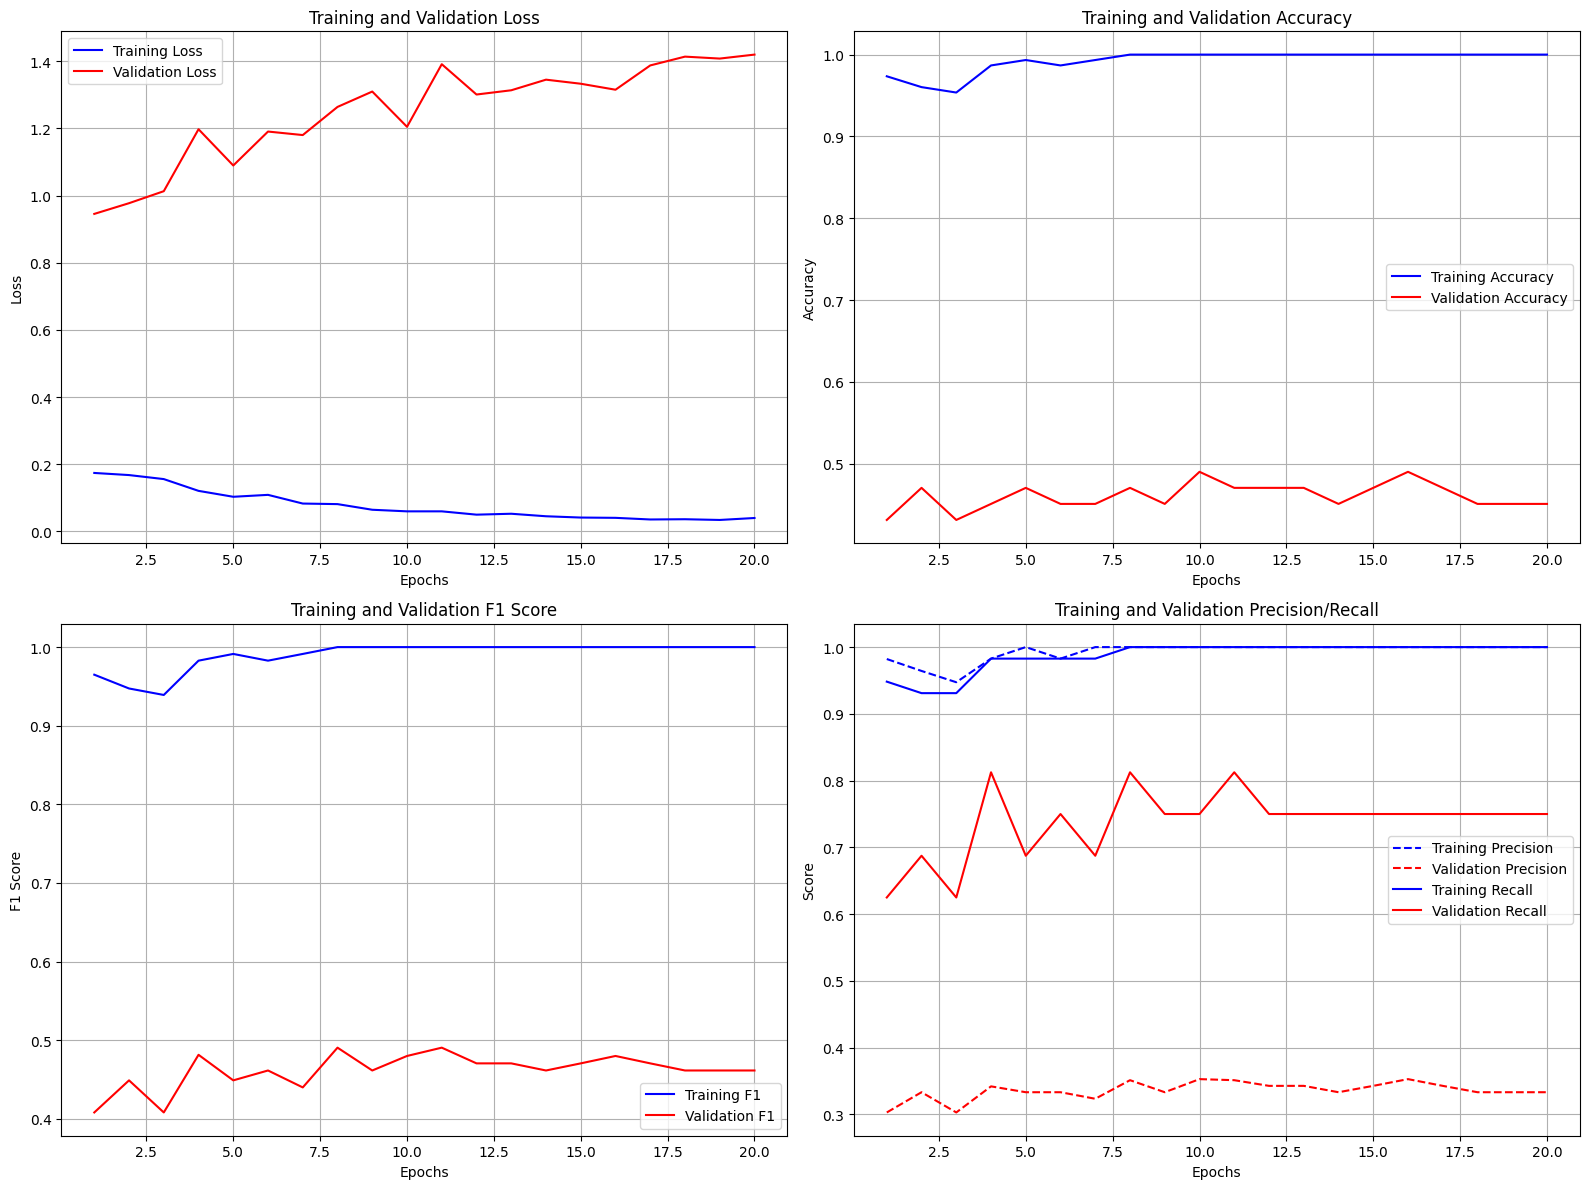


Training complete. Best validation F1 score: 0.4906
Training metrics saved to tumor_models_augment/training_metrics.png
Detailed metrics data saved to tumor_models_augment/training_metrics.csv


In [14]:
# Train the model
best_model_path = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=20,  # Start with smaller number for testing
    learning_rate=1e-4,
    weight_decay=0.01,
    save_dir='tumor_models_augment'
)